# Outline

## Make linegraphs to plot numbers and or percentages of various molecularly defined cell types as a function of mediolateral position within the ZI


In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

In [2]:
def make_ML_dictionary(mediolateralDF): 
    
    
    """
        This function creates a dictionary from a dataframe, wherein one column containing the Filenames becomes
        the keys of the dictionary, and the other column containing the ML positions of those images, becomes the
        values of the dictionary
    """
    
    mediolateralDF = mediolateralDF[['Filename','ML Position']]

    #Create a dictionary wherein Keys = Filenames and Values = Mediolateral positions
    dict_image_MLposition = {}

    for i in range(len(mediolateralDF)):
        #The part of the filename we want is 16 characters long, so slices the string to the 16th character 
        #When creating the filename
        dict_image_MLposition[mediolateralDF.iloc[i,0][:16]] = mediolateralDF.iloc[i,1]
    
    return dict_image_MLposition

In [3]:
def make_percent_cells_DF(DF, probelist, parentprobe):
    
    """
        This function calculates the fraction of the total "parentprobe" (most inclusive, widely expressed transcript) 
        expressing population that is positive for each combination of transcripts probed in the image set. These 
        percentage/fractional values are appended to the dataframe as new columns
        
        The function requires 3 input arguments:
            1. DF - the dataframe to be processed (typically an Image Level DataFrame output from CellProfiler)
            2. probelist - a list of the probes included in the image set
            3. parentprobe - the most broadly stratifying (highest tier) marker to be further subdivided by other probes
          
        The function returns the following output:
            1. percentplotDF - the dataframe with the added percentage columns
    """
    
    percentlist = []
    markerpercentlist = []
    imagelist = []
    MLlist = []
    MouseIDlist = []
    
    cols = DF.columns.tolist()
    cols = [i for i in cols if i.find('Count_') != -1]
    
    for column in cols:
        
        for i in range(len(DF)):

            percentage = DF[column].iloc[i] / DF['Count_' + parentprobe].iloc[i]
            percentlist.append(percentage)
            percenttype = column + ' / ' + 'Count_' + parentprobe
            markerpercentlist.append(percenttype)
            #AAA = DF.iloc[i]['FileName_RAW']
            #image = AAA[AAA.find('MAX_')+4:AAA.find('_4C')]
            imagelist.append(DF.iloc[i]['FileName_RAW'])
            MLlist.append(DF['Relative Image Position'].iloc[i])
            MouseIDlist.append(DF['Mouse ID'].iloc[i])
                       

    percentplotDF = pd.DataFrame()
    percentplotDF['Relative Image Position'] = MLlist    
    percentplotDF['Image']  = imagelist
    percentplotDF['Percent'] = percentlist
    percentplotDF['MarkerCombo'] = markerpercentlist
    percentplotDF['Mouse ID'] = MouseIDlist
    
    return percentplotDF


In [4]:
def make_percent_sum_DF(DF, probelist):
    
    """
        This function calculates the percentage of probe+ cells in the entire image set that are positive for
        other probes and probe combinations.
        
        The function requires 2 input arguments:
            1. DF - the image level dataframe containing the counts for the entire image set
            2. probelist - a list of the transcripts probed in the image set 
        
        The function returns the following output:
            1. sumDF - a dataframe with the cross-image sums and image set-wide calculated percentages 
                       for colocalization
    """
    
    cpsumDF = DF.sum()
    percentlist = []
    markerpercentlist = []

    
    cols = DF.columns.tolist()
    cols = [i for i in cols if i.find('Count_') != -1]
    
    for column1 in cols:
        for column2 in cols:
            percentage = cpsumDF[column1]/cpsumDF.loc[column2]
            percentlist.append(percentage)
            percenttype = column1 + ' / ' + column2
            markerpercentlist.append(percenttype)

    sumDF = pd.DataFrame()
    sumDF['MarkerCombo'] = markerpercentlist
    sumDF['Percent'] = percentlist
    
    
    return sumDF

# Make DataFrames from: 
## 1) Cell Profiler Output Image.csv
## 2) .csv containing the file names and their associated mediolateral positions

In [5]:
cellprofilerDF = pd.read_csv('/Volumes/ryanKast/RKDATA/ConfocalData/SDC/RNAscope/V2/ZI/Sagittal/FINALSET_FIRSTTIER/Gad2_Pax6_Kcng2/CellProfilerOutput/3Mice_110222/Kcng2Pax6Gad2_CellPoseGad2_110222Image.csv')
filename_MLpositionDF = pd.read_csv("/Volumes/ryanKast/RKDATA/ConfocalData/SDC/RNAscope/V2/ZI/Sagittal/FINALSET_FIRSTTIER/RNAscope_Filename_MLposition.csv")


# Calculate the counts for any cell types that weren't explicitly measured by CellProfiler, but that can be calculated by adding and subtracting other celltypes

### "Pure" Cell Types: 
Reflect double positive cells that are not triple positive (e.g. Pure Kcng2_Gad2 cells do not express Pax6)

### "Only" Cell Types:
Reflect the counts of singly positive cells (e.g. Count_Gad2_only cells express Gad2, but not other genes)

In [6]:
cellprofilerDF['Count_CT_Pure_Kcng2_Gad2'] = cellprofilerDF['Count_CT_Kcng2_Gad2'] - cellprofilerDF['Count_CT_Kcng2_Pax6_Gad2']


In [7]:
cellprofilerDF['Count_CT_Pure_Pax6_Gad2'] = cellprofilerDF['Count_CT_Pax6_Gad2'] - cellprofilerDF['Count_CT_Kcng2_Pax6_Gad2']


In [8]:
MouseIDs =['6500-5', '6700-1', '6700-2', '7200-1', '7200-2', '4-4-1', '4-4-2']

In [9]:
#Make the filenames simpler
TruncateFilenames = []
MouseList = []

for i in range(len(cellprofilerDF)):
    old = cellprofilerDF.iloc[i]['FileName_RAW']
    new = old[old.find('MAX_')+4:old.find('_4C')]
    TruncateFilenames.append(new)
    for ID in MouseIDs:
        if cellprofilerDF.iloc[i]['FileName_RAW'].find(ID) >= 0:
            MouseList.append(ID)
            
cellprofilerDF['FileName_RAW'] = TruncateFilenames
cellprofilerDF['Mouse ID'] = MouseList

# Run Functions

DEV_NEED_NOTE: With addition of two new mice (11-2-22), we can't use the med_lat_dict without first updating it to include the ML levels for the new images

In [10]:
#med_lat_dict = make_ML_dictionary(filename_MLpositionDF)
#cellprofilerDF = modify_cp_dataframe(cellprofilerDF, ImageNumDict, MouseIDs, bins = True)


In [11]:
#percentplotDF[percentplotDF['MarkerCombo'] ==  'Count_CT_Kcng2_Pax6_Gad2 / Count_CT_Gad2Neurons']
cols = [i for i in cellprofilerDF.columns.tolist() if i.find('Count') >= 0]

In [12]:
parentcols = [i for i in cols if i.find('Count_CT_Gad2Neurons') >= 0]

In [13]:
for a in cols:
    
    for b in parentcols:
        
        new_col = a + " / " + b
        cellprofilerDF[new_col] = cellprofilerDF[a] / cellprofilerDF[b]
            

In [14]:
percentcols = [i for i in cellprofilerDF.columns.tolist() if i.find('/ Count_CT_Gad2Neurons') >= 0]

#cellprofilerDF[percentcols]

In [15]:
imagelist = cellprofilerDF['FileName_RAW'].unique().tolist()

In [16]:
cellprofilerDF['Mouse ID']

0      4-4-1
1      4-4-1
2      4-4-1
3      4-4-1
4      4-4-1
5      4-4-1
6      4-4-1
7      4-4-1
8      4-4-1
9      4-4-1
10     4-4-1
11     4-4-1
12     4-4-1
13     4-4-1
14     4-4-1
15     4-4-1
16     4-4-2
17     4-4-2
18     4-4-2
19     4-4-2
20     4-4-2
21     4-4-2
22     4-4-2
23     4-4-2
24     4-4-2
25     4-4-2
26     4-4-2
27     4-4-2
28     4-4-2
29     4-4-2
30     4-4-2
31     4-4-2
32    7200-2
33    7200-2
34    7200-2
35    7200-2
36    7200-2
37    7200-2
38    7200-2
39    7200-2
40    7200-2
41    7200-2
42    7200-2
43    7200-2
44    7200-2
Name: Mouse ID, dtype: object

In [17]:
#Align images from Different Mice by dropping images (too lateral, too medial, poor quality)
finalset = [i for i in imagelist if i not in ['4-4-1-1A-S1', #too lateral to match up
                                   '4-4-1-4A-S3', #too medial to match up
                                   '4-4-1-4A-S4', #too medial to match up 
                                   '4-4-2-1A-S1', #too lateral to match up
                                   '4-4-2-4A-S3', #too medial to match up
                                   '4-4-2-4A-S4']] #too medial to match up

cellprofilerDF_3mice = cellprofilerDF[cellprofilerDF['FileName_RAW'].isin(finalset)]

DFlist = []
for ID in ['4-4-1', '4-4-2', '7200-2']:
    subset = cellprofilerDF_3mice[cellprofilerDF_3mice['Mouse ID'] == ID]
    subset.insert(0,'Relative Image Position', range(1,14))
    DFlist.append(subset)
    
cellprofilerDF_3mice = pd.concat(DFlist) 

In [18]:
percentplotDF = make_percent_cells_DF(DF=cellprofilerDF_3mice, 
                                      probelist = ['Pax6','Kcng2'],
                                      parentprobe = 'CT_Gad2Neurons')

In [19]:
percentplotDF

,Relative Image Position,Image,Percent,MarkerCombo,Mouse ID
0,1,4-4-1-1A-S2,5.055769,Count_CT_DAPI / Count_CT_Gad2Neurons,4-4-1
1,2,4-4-1-1A-S3,7.464583,Count_CT_DAPI / Count_CT_Gad2Neurons,4-4-1
2,3,4-4-1-1A-S4,7.459574,Count_CT_DAPI / Count_CT_Gad2Neurons,4-4-1
3,4,4-4-1-2A-S1,7.793103,Count_CT_DAPI / Count_CT_Gad2Neurons,4-4-1
4,5,4-4-1-2A-S2,6.886497,Count_CT_DAPI / Count_CT_Gad2Neurons,4-4-1
...,...,...,...,...,...
697,9,7200-2-3A-S3b,0.000539,Count_CT_Pure_Pax6_Gad2 / Count_CT_Gad2Neurons...,7200-2
698,10,7200-2-3A-S4,0.000595,Count_CT_Pure_Pax6_Gad2 / Count_CT_Gad2Neurons...,7200-2
699,11,7200-2-4A-S1,0.000529,Count_CT_Pure_Pax6_Gad2 / Count_CT_Gad2Neurons...,7200-2
700,12,7200-2-4A-S2,0.000792,Count_CT_Pure_Pax6_Gad2 / Count_CT_Gad2Neurons...,7200-2


# Plots

In [24]:
savedir = '/Volumes/ryanKast/RKDATA/ConfocalData/SDC/RNAscope/V2/ZI/Sagittal/FINALSET_FIRSTTIER/PythonAnalysis/Plots/Gad2Pax6Kcng2/3Mice/'
sns.set_theme(style = 'white', 
              font = 'arial',
              font_scale = 1.3)


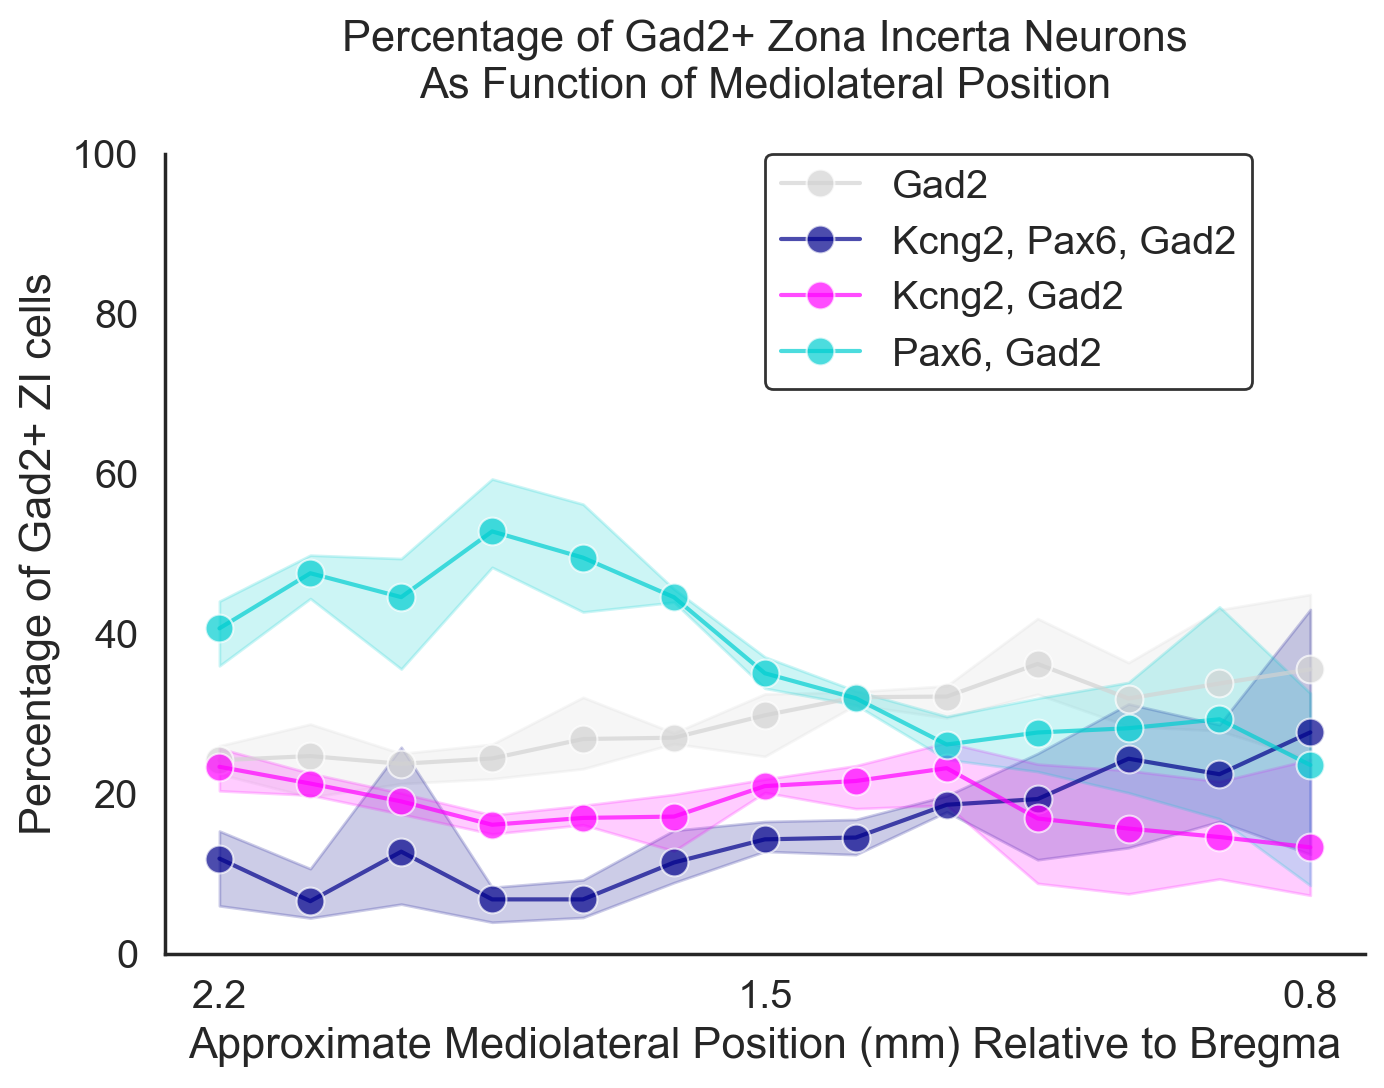

In [26]:
fig = plt.figure(figsize = (6,4), dpi = 200)

ax1 = fig.add_axes([0,0,1,1])
ax1.set_ylim(0,100)
ax1.set_ylabel('Percentage of Gad2+ ZI cells')
ax1.set_xlabel('Approximate Mediolateral Position (mm) Relative to Bregma')
ax1.set_xticks(ticks = [1,7,13])
ax1.set_xticklabels(labels = ['2.2', '1.5', '0.8'])

#cm = ['Purple', 'Green', 'Orangered']

cm = ['lightgrey','darkblue', 'magenta', 'darkturquoise']

plt.title('Percentage of Gad2+ Zona Incerta Neurons\nAs Function of Mediolateral Position', pad = 20)


sns.lineplot(data=percentplotDF[percentplotDF['MarkerCombo'].isin([
                          'Count_CT_Pure_Kcng2_Gad2 / Count_CT_Gad2Neurons',
                          'Count_CT_Pure_Pax6_Gad2 / Count_CT_Gad2Neurons',
                          'Count_CT_Kcng2_Pax6_Gad2 / Count_CT_Gad2Neurons',
                          'Count_CT_Gad2only / Count_CT_Gad2Neurons'])], 
             x='Relative Image Position', 
             y=percentplotDF['Percent'] * 100, 
             hue = 'MarkerCombo',
             hue_order = ['Count_CT_Gad2only / Count_CT_Gad2Neurons',
                          'Count_CT_Kcng2_Pax6_Gad2 / Count_CT_Gad2Neurons',
                          'Count_CT_Pure_Kcng2_Gad2 / Count_CT_Gad2Neurons',
                          'Count_CT_Pure_Pax6_Gad2 / Count_CT_Gad2Neurons',],
                         
             marker = "o",
             markersize = 10,
             palette = cm,
             ax = ax1,
             alpha = 0.7
             ).set_ylim(0,100)

h,l = ax1.get_legend_handles_labels()

sns.despine(top = True, right = True)

ax1.legend(bbox_to_anchor = (0.5,1), 
           loc=2, 
           borderaxespad = 0, 
           handles = h,
           labels = ['Gad2', 
                     'Kcng2, Pax6, Gad2',
                     'Kcng2, Gad2',
                     'Pax6, Gad2'],
           edgecolor = 'Black'
           )





##plt.savefig(savedir + 'LinePlot_Gad2Pax6Kcng2_ML_Percent_AllMice.svg',  bbox_inches='tight')

In [27]:
percentsumDF = make_percent_sum_DF(cellprofilerDF, ['Pax6','Kcng2'])

In [28]:
percentsumDF[percentsumDF['Percent'] < 1.01]

,MarkerCombo,Percent
0,Count_CT_DAPI / Count_CT_DAPI,1.000000
18,Count_CT_Gad2Neurons / Count_CT_DAPI,0.140784
19,Count_CT_Gad2Neurons / Count_CT_Gad2Neurons,1.000000
36,Count_CT_Gad2Pax6neg / Count_CT_DAPI,0.065797
37,Count_CT_Gad2Pax6neg / Count_CT_Gad2Neurons,0.467364
...,...,...
316,Count_CT_Pure_Pax6_Gad2 / Count_CT_Gad2Neurons...,0.355600
317,Count_CT_Pure_Pax6_Gad2 / Count_CT_Gad2Neurons...,0.764399
319,Count_CT_Pure_Pax6_Gad2 / Count_CT_Gad2Neurons...,0.990690
321,Count_CT_Pure_Pax6_Gad2 / Count_CT_Gad2Neurons...,0.664923


In [29]:
cols = [x for x in percentplotDF['MarkerCombo'].unique() if 
          (x.find('/ Count_Gad2Neurons') != -1) 
        & (x.find('Count_Gad2Neurons ') == -1) 
        & (x.find('Pure') == -1)]



In [30]:
len(cellprofilerDF)

45

In [31]:
percentsumDF = percentsumDF.drop_duplicates('MarkerCombo')

In [32]:
cellprofilerDF[cellprofilerDF['Mouse ID'] == '7200-2']['Count_CT_Kcng2_Pax6_Gad2'].sum()

1156.0

In [33]:
percentplotDF['MarkerCombo'].str[6:]

0                         CT_DAPI / Count_CT_Gad2Neurons
1                         CT_DAPI / Count_CT_Gad2Neurons
2                         CT_DAPI / Count_CT_Gad2Neurons
3                         CT_DAPI / Count_CT_Gad2Neurons
4                         CT_DAPI / Count_CT_Gad2Neurons
                             ...                        
697    CT_Pure_Pax6_Gad2 / Count_CT_Gad2Neurons / Cou...
698    CT_Pure_Pax6_Gad2 / Count_CT_Gad2Neurons / Cou...
699    CT_Pure_Pax6_Gad2 / Count_CT_Gad2Neurons / Cou...
700    CT_Pure_Pax6_Gad2 / Count_CT_Gad2Neurons / Cou...
701    CT_Pure_Pax6_Gad2 / Count_CT_Gad2Neurons / Cou...
Name: MarkerCombo, Length: 702, dtype: object

In [36]:
cols2 = ['Count_CT_Pure_Kcng2_Gad2',
          'Count_CT_Pure_Pax6_Gad2',
          'Count_CT_Kcng2_Pax6_Gad2',
          'Count_CT_Gad2only']



trim = cellprofilerDF#[cellprofilerDF['Mouse ID'] == '4-4-2']
#trim = cellprofilerDF

fig = px.pie(trim.sum()[cols2], 
             names = trim.sum()[cols2].index, 
             values = trim.sum()[cols2],
             color_discrete_sequence= ['darkturquoise','lightgrey', 'magenta', 'darkblue'],
            )


config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 700,
    'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
  }
}

#fig.write_image(savedir + 'PieChart_4-4-2.svg')
fig.show()

Text(0, 0.5, 'Fraction of Gad2+ ZI cells')

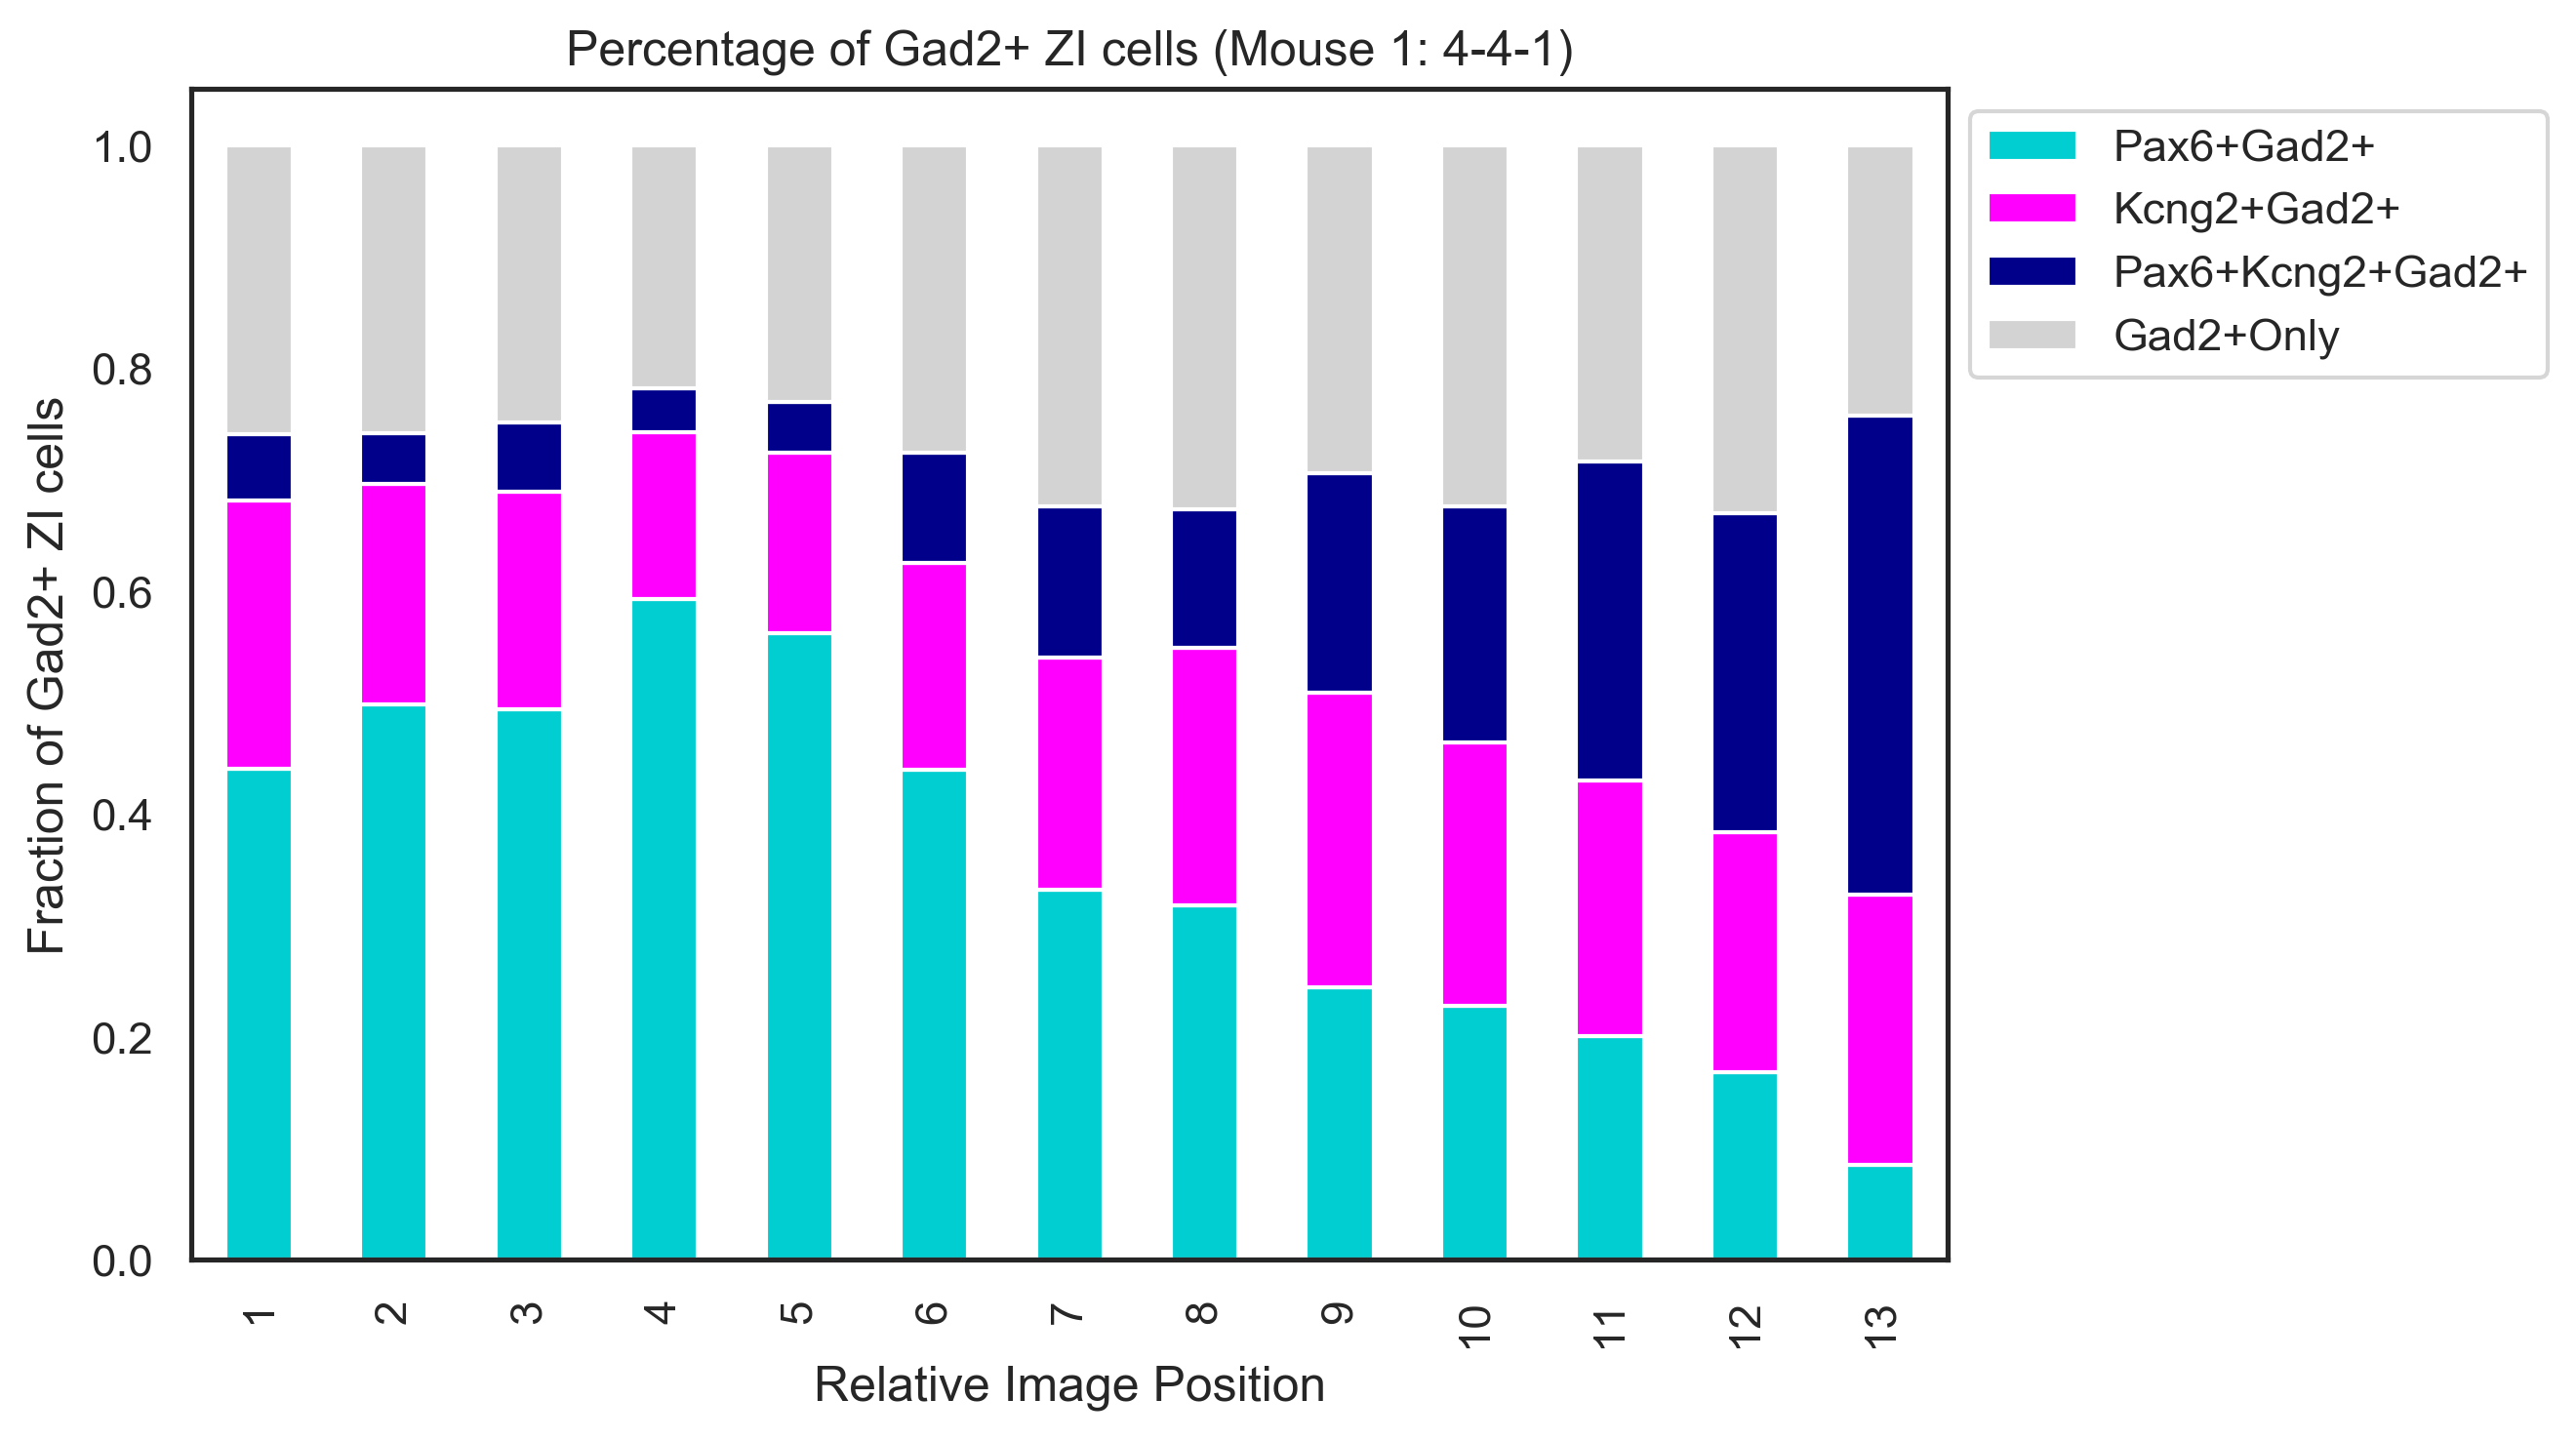

In [35]:
fig = plt.figure(figsize = (6,4),dpi=300)

ax1 = fig.add_axes([0,0,1,1])
ax1.set_title('Percentage of Gad2+ ZI cells (Mouse 1: 4-4-1)')
ax1.set_xlabel('ML Position Relative to Bregma (mm)')

cellprofilerDF['FileName_RAW'] = cellprofilerDF['FileName_RAW'].str[0:16]
percentcols = [i for i in cellprofilerDF.columns.tolist() if i.find('/ Count_Gad2Neurons') >= 0]



choose = [
          'FileName_RAW',
          'Relative Image Position',
          'Count_CT_Pure_Pax6_Gad2 / Count_CT_Gad2Neurons',
          'Count_CT_Pure_Kcng2_Gad2 / Count_CT_Gad2Neurons',
          'Count_CT_Kcng2_Pax6_Gad2 / Count_CT_Gad2Neurons',
          'Count_CT_Gad2only / Count_CT_Gad2Neurons']

subset = cellprofilerDF_3mice[cellprofilerDF_3mice['Mouse ID'] == '4-4-1']

subset[choose].plot(kind = 'bar', 
                              stacked= True, 
                              x = 'Relative Image Position',
                              ax = ax1,
                              color = ['darkturquoise', 'magenta', 'darkblue', 'lightgrey']) 
                                        
                                       

plt.legend(bbox_to_anchor=(1.0, 1.0), labels = ['Pax6+Gad2+', 
                                                'Kcng2+Gad2+', 
                                                'Pax6+Kcng2+Gad2+',
                                                'Gad2+Only'])
plt.ylabel('Fraction of Gad2+ ZI cells')
##plt.savefig(savedir + 'StackedBarPlot_Gad2Pax6Kcng2_4-4-1.svg', facecolor = 'white', bbox_inches = 'tight')

In [36]:
cols2 = [x for x in cellprofilerDF.sum().index.tolist() if 
  (x.find('Gad2') != -1)
& (x.find('Count') != -1)
& (x.find('Gad2Neurons') == -1)]




fig = px.pie(cellprofilerDF.sum()[cols2], 
             names = cellprofilerDF.sum()[cols2].index, 
             values = cellprofilerDF.sum()[cols2])
fig.show()

In [ ]:
cols = [x for x in percentplotDF['MarkerCombo'].unique() if 
          (x.find('/ Count_Gad2Neurons') != -1) 
        & (x.find('Count_Gad2Neurons ') == -1) 
        & (x.find('Pure') != -1)]



In [ ]:
cols2 = [x for x in cellprofilerDF.sum().index.tolist() if 
          ((x.find('Pure')) != -1) or
          ((x.find('Gad2') != -1)
        & (x.find('Count_Kcng2_Pax6_Gad2') != -1)
        & (x.find('Gad2Neurons') == -1))]


In [ ]:
x = pd.read_csv('Sum_of_Counts.csv', names = ['MarkerCombo', 'Number'])

In [ ]:
a = pd.DataFrame(columns = ['MarkerCombo', 'Number'],
             data = {'MarkerCombo': 'Gad2 Only',
                     'Number': [x.iloc[9]['Number'] - x.iloc[12]['Number'] - x.iloc[13]['Number'] - x.iloc[4]['Number']]})

In [ ]:
xx = pd.concat([x,a])

In [ ]:
xy = xx[xx['MarkerCombo'].isin(['Pure Kcng2_Gad2', 'Pure Pax6_Gad2', 'Count_Kcng2_Pax6_Gad2','Gad2 Only'])]


In [ ]:
xx['Mouse ID'] = '7200-1'

In [ ]:
names = ['Kcng2+Pax6+Gad2+', 'Kcng2+Gad2+', 'Pax6+Gad2+', 'Gad2 only']
xy['MarkerCombo'] = names

In [ ]:
xy

In [ ]:
fig =px.pie(data_frame=xy, 
       title = 'Percentage Of Gad2+ Cells in the ZI',
       values='Number',
       names= 'MarkerCombo', 
       hover_name = 'MarkerCombo',
       color_discrete_sequence= [ 'lightgray', 'limegreen', 'darkviolet', 'darkorange'],
       hole = 0.5,
       width = 700,
       height = 700)

#pio.write_image(fig, 'Gad2Pax6Kcng2Pie_WithoutGad2Only.pdf')
fig

In [ ]:
ls

In [ ]:
px.pie(data_frame=xy, 
       title = 'Percentage Of Gad2+ Cells in the ZI',
       values='Number',
       hover_name = ['Gad2 Only', 'Pax6+Gad2+', 'Kcng2+Gad2+', 'Kcng2+Pax6+Gad2+'],
       names= 'MarkerCombo', 
       labels = {'MarkerCombo': 'Gad2 Only', 
                 'MarkerCombo':'Pax6+Gad2+', 
                 'MarkerCombo':'Kcng2+Gad2+',
                 'MarkerCombo':'Kcng2+Pax6+Gad2+'},
       
       color_discrete_sequence= ['lightgray', 'limegreen', 'darkviolet', 'darkorange'],
       hole = 0.6,
   )


In [ ]:
px.pie(data_frame=xy, 
       values='Number',
       labels = ['Gad2 Only', 'Pax6+Gad2+', 'Kcng2+Gad2+', 'Kcng2+Pax6+Gad2+'],
       names='MarkerCombo', 
       color_discrete_sequence= ['lightgray', 'limegreen', 'darkviolet', 'darkorange'],
       )